In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns


HMNS VS Features

In [2]:
df = pd.read_csv("gorilla_tug_of_war.csv")

df.head()


,WHT,FRC,AGE,DSI,SUS,GND,HMNS
0,199.4,145,40,603,Western Lowland,Male,224
1,197.7,146,22,268,Western Lowland,Male,220
2,136.0,117,30,47,Western Lowland,Female,144
3,138.0,100,36,52,Western Lowland,Female,174
4,196.2,102,35,488,Mountain,Male,216


In [3]:
x = pd.get_dummies(df["SUS"],prefix="SUS", drop_first=True,dtype=int)
x

,SUS_Grauer's,SUS_Mountain,SUS_Western Lowland
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
495,0,0,0
496,0,0,1
497,0,1,0
498,0,1,0


HMNS vs WHT
Train R2:  0.35794099206212004
Test R2:  0.39047044886411186



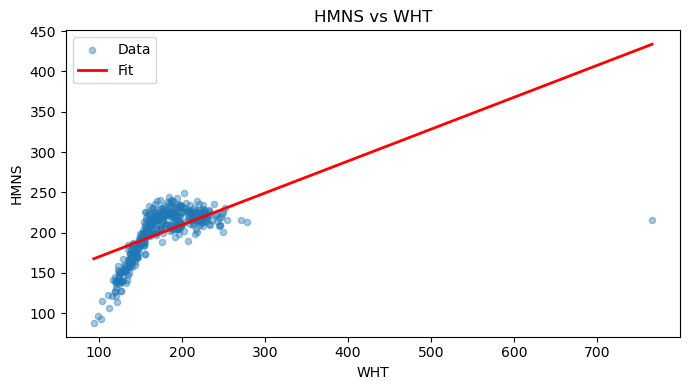

HMNS vs AGE
Train R2:  8.458877420403077e-06
Test R2:  -0.13942165941839324



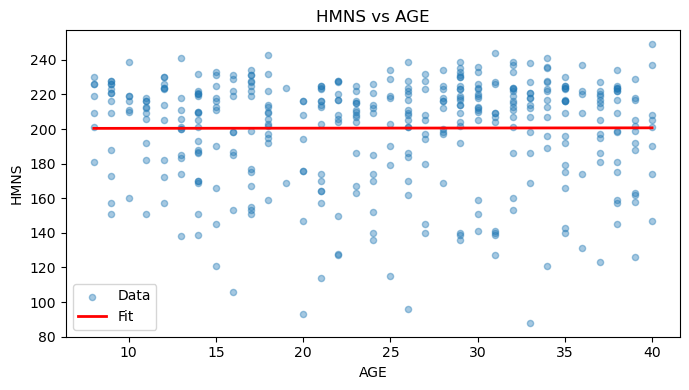

HMNS vs DSI
Train R2:  7.587111263696045e-06
Test R2:  -0.14088293065760027



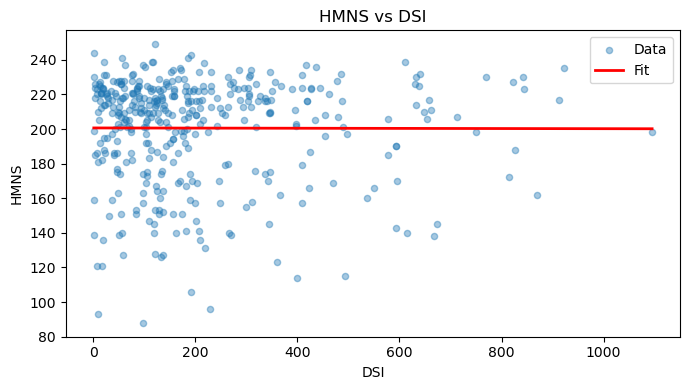

HMNS vs SUS
Train R2:  0.0903088499147392
Test R2:  -0.13050694000146779



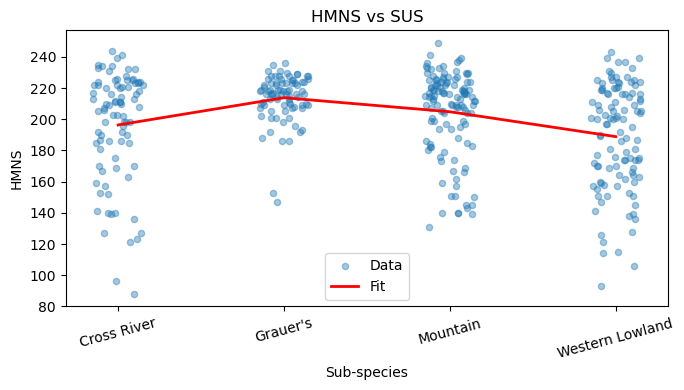

In [4]:
feautures = ["WHT", "AGE", "DSI", "SUS"]
y = df[["HMNS"]]

#  Prepare integer codes for SUS (for plotting)
df['SUS_code'] = df['SUS'].astype('category').cat.codes

# Capture the category names for tick labels
sus_categories = df['SUS'].astype('category').cat.categories.to_list()

for feat in feautures:

    if feat != "SUS":

         X = df[[feat]]

    else:

        X = pd.get_dummies(df[["SUS"]],prefix="SUS", drop_first=True, dtype=int )

       

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"HMNS vs {feat}")
    print("Train R2: ",r2_train)
    print("Test R2: ", r2_test)
    print("")


      # 8. Plot scatter + line
    plt.figure(figsize=(7,4))
    
    if feat != "SUS":
        # Numeric features: as before
        x_vals = X_train[feat].to_numpy().flatten()
        y_vals = y_train.to_numpy().flatten()
        y_pred = y_train_pred.flatten()
        
        # Sort for smooth line
        idx        = np.argsort(x_vals)
        x_sorted   = x_vals[idx]
        y_sorted   = y_pred[idx]
        
        plt.scatter(x_vals, y_vals, alpha=0.4, s=20, label="Data")
        plt.plot(x_sorted, y_sorted, color="red", linewidth=2, label="Fit")
        plt.xlabel(feat)
        plt.ylabel("HMNS")
    
    else:
        
        codes      = df.loc[y_train.index, 'SUS_code'].to_numpy().flatten()
        actuals    = y_train.to_numpy().flatten()
        preds      = y_train_pred.flatten()
        
        
        jitter     = np.random.uniform(-0.15, 0.15, size=len(codes))
        x_jittered = codes + jitter
        
        plt.scatter(x_jittered, actuals, alpha=0.4, s=20, label="Data")
        
        # Compute mean prediction per code and draw line
        mean_df    = pd.DataFrame({'code': codes, 'pred': preds})
        grouped    = mean_df.groupby('code')['pred'].mean().reset_index()
        plt.plot(grouped['code'], grouped['pred'], color="red", linewidth=2, label="Fit")
        
        # Replace x-ticks with category names
        plt.xticks(range(len(sus_categories)), sus_categories, rotation=15)
        plt.xlabel("Sub-species")
        plt.ylabel("HMNS")
    
    plt.title(f"HMNS vs {feat}")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Part 2: Multiple‐Variable Regression**

WHT + AGE        Train R²: 0.359  Test R²: 0.392


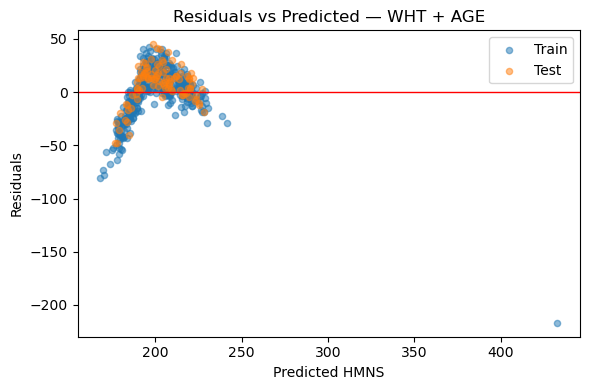

WHT + DSI        Train R²: 0.359  Test R²: 0.404


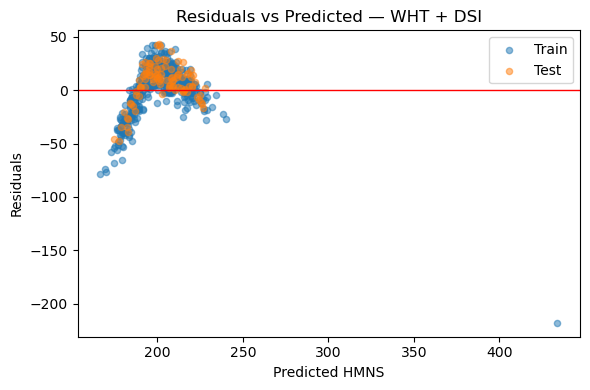

WHT + AGE + DSI  Train R²: 0.361  Test R²: 0.407


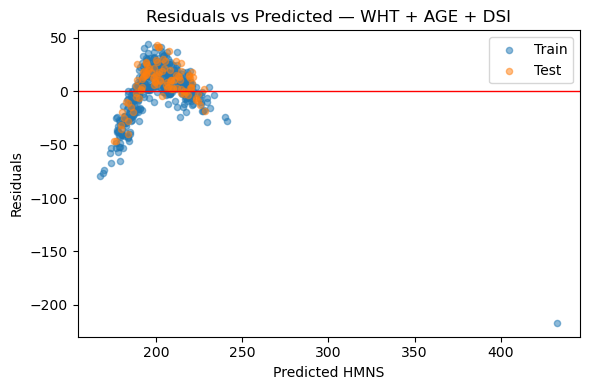

WHT + DSI + SUS  Train R²: 0.370  Test R²: 0.374


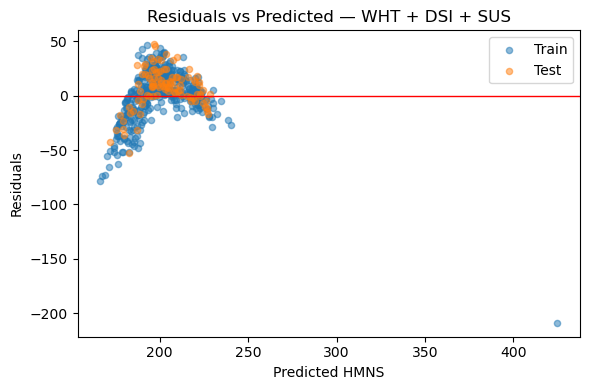

All Features     Train R²: 0.371  Test R²: 0.377


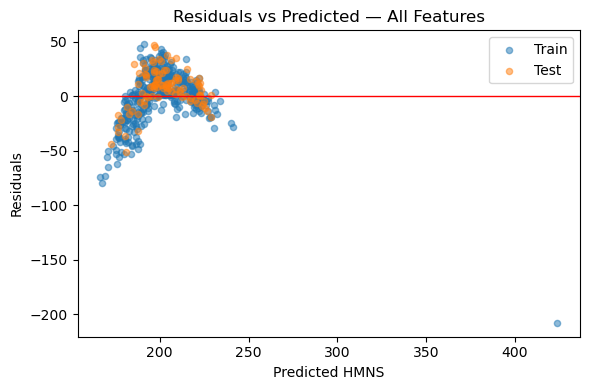

In [ ]:


# Build df_all 
sus_dummies = pd.get_dummies(df["SUS"], prefix="SUS", drop_first=True, dtype=int)
df_all = pd.concat([ df[["WHT","AGE","DSI"]] , sus_dummies ], axis=1)

# Fixed train/test split of indices
train_idx, test_idx = train_test_split(df_all.index, test_size=0.2, random_state=42)

#  fit, score, and plot residuals
def evaluate_model(name, features):
    # Expand "SUS" into the dummy columns automatically
    cols = []
    for f in features:
        if f == "SUS":
            cols += sus_dummies.columns.tolist()
        else:
            cols.append(f)

    # Slice out X and y
    X_train = df_all.loc[train_idx, cols]
    X_test  = df_all.loc[test_idx,  cols]
    y_train = df.loc[train_idx, "HMNS"]
    y_test  = df.loc[test_idx,  "HMNS"]

    # Fit & predict
    model = LinearRegression().fit(X_train, y_train)
    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)

    # Print R²
    print(f"{name:15s}  Train R²: {r2_score(y_train, y_tr):.3f}  Test R²: {r2_score(y_test, y_te):.3f}")

    # Plot residuals vs. predicted
    res_tr = y_train - y_tr
    res_te = y_test  - y_te

    plt.figure(figsize=(6,4))
    plt.scatter(y_tr, res_tr, alpha=0.5, label="Train", s=20)
    plt.scatter(y_te, res_te, alpha=0.5, label="Test",  s=20)
    plt.axhline(0, color="red", linewidth=1)
    plt.title(f"Residuals vs Predicted — {name}")
    plt.xlabel("Predicted HMNS")
    plt.ylabel("Residuals")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Defining the models  
combos = {

    "WHT + AGE":["WHT","AGE"],
    "WHT + DSI":["WHT","DSI"],
    "WHT + AGE + DSI":["WHT","AGE","DSI"],
    "WHT + DSI + SUS":["WHT","DSI","SUS"],
    "All Features":["WHT","AGE","DSI","SUS"],
}

# Evaluate them
for name, feats in combos.items():
    evaluate_model(name, feats)


**Baseline (WHT):**

Test R2 = 0.390. This already shows us 39% of variance.

**1. WHT --> WHT + AGE:**

Test R2 increases by 0.002 (from 0.390 --> 0.392). AGE carries almost no additional signal beyond WHT as its single variable R2 was near 0. It just adds complexity without meaninful gain.

**WHT + AGE --> WHT + DSI:**
Test R2 increases by 0.012 (from 0.392 --> 0.404). DSI provides additional information about the gorillas health whih boosts the predictive power when paired with weight.

**WHT + DSI --> WHT + AGE + DSI:**
Test R2 increases by 0.003 (from 0.404 --> 0.407). Adding AGE now yields small improvement as AGE itself is weak, but in combination with te 2 other fetures (WHT + DSI) may help a bit.

**WHT + DSI → WHT + DSI + SUS**
Test R2 drop by 0.033 (from 0.407 --> 0.374). Meaning the OHE of SUS overfits the training set - which actually increased, but hin trun hurts generalization.

**WHT + DSI + SUS --> ALl features:**
Test R2 increases by 0.003 (from 0.374 --> 0.377) and is still below the best we have seen. Adding everything together slightly recoers from the SUS overfit, but never beats WHT + AGE +DSI.



**WHICH MODELS WORK BEST?**

Best Test R2:
WHT + AGE + DSI acheived the highest test set R2 (0.407). By adding AGE to WHT + DSI achieves only a small increase from 0.361 - 0.361 (train set) and 0.404 - 0.407 (test set), so it seems as DSI is doing most of the work with WHT. 

Overfitting Check:
The gap between Train R2 and Test R2 is small for both WHT + DSI (0.359 --> 0.404) and WHT + AGE + DSI (0.361 --> 0.407) which indicates good generalization.

All features:
If we include every predictor (WHT, AGE, DSI and SUS), this increases Train R2 slightly (0.371), but actually reduces Test R2 (0.377). That indicates that the categorical SUS variables add noise rather than signal, once continuous variables are included.

**INTERPRETATION OF PLOTS:**

In each case the vertical distane from the red zero line are fairly symetrically scattered with no common pattern, which indicates that the linear model is appropriate.
The WHT + AGE + DSI plot shows the tightest, residual distribution around 0, aligning with its slightly higher test R2.

**CONCLUSION:**
The best model is the WHT + AGE + DSI, becasue it maximizes test R2 (0.407), as this shows minimal overfitting and has well- behaved risiduals.


In [ ]:
import statsmodels.api as sm

# Pick your final features
features = ["WHT", "AGE", "DSI"]

# Extract X and y and convert to float
X_final = df[features].astype(float)
y_final = df["HMNS"].astype(float)

# Add intercept
X_sm = sm.add_constant(X_final)

# Fit OLS
ols_model = sm.OLS(y_final, X_sm).fit()

#Show full summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   HMNS   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     101.4
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.36e-51
Time:                        12:29:48   Log-Likelihood:                -2281.8
No. Observations:                 500   AIC:                             4572.
Df Residuals:                     496   BIC:                             4588.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.8870      5.462     22.499      0.0

In [18]:
from sklearn.model_selection import cross_val_score

X = df[["WHT","AGE","DSI"]]
y = df["HMNS"]
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print("5-fold CV R²:", np.round(cv_scores, 3))
print("Mean CV R²:", np.mean(cv_scores).round(3))


5-fold CV R²: [-1.235  0.458  0.448  0.448  0.491]
Mean CV R²: 0.122
